# Identifying sets of key players in a social network (docs/cmotkeyplayer.pdf)

# KPP-NEG algorithm

## KPP-NEG is defined as the identification of key players for the purpose of disrupting or fragmenting the network by removing the key nodes.

The first key player problem is defined in terms of the extent to which the network depends on its key players to maintain its cohesiveness. 
I refer to this as the “Key Player Problem/Negative” (KPP-Neg) because we measure importance in the breach—the amount of reduction in cohesiveness of the network that would occur if the nodes were not present. 
KPP-Neg arises in the public health context whenever we need to select a subset ofpopulation members to immunize or quarantine in order to optimally contain an epidemic. 
In the military or criminal justice context the problem arises when we need to select a small number of players in a criminal network to neutralize (e.g., by arresting, exposing or discrediting) in order to maximally disrupt the network’s ability to mount coordinated action.

A formal definition: 
Given a social network (represented as an undirected graph), find a set of k nodes (called a kp-set of order k) such that removing the kp-set would result in a residual network with the least possible cohesion.

KPP-Neg involves fragmenting a network into components, or, failing that, making path lengths between nodes so large as to be practically disconnected. 

fragmentation measure F

sizes ($s_{k}$) of each component (indexed by k)

number of nodes n

matrix R in which $r_{ij} = 1$ if i can reach j and $r_{ij} = 0$ otherwise

$F = 1 - \frac{2 \sum_{i}\sum_{j<i}r_{ij}}{n(n-1)}$

F achieves minimum value of 0 when the network consists of a single component

The DF measure is identical to F when all components are complete (i.e., each component is also a clique). However, when distances within components are greater than 1, the measure captures the relative cohesion of the components.

Like the F measure, DF achieves its maximum value of 1.0 when the graph consists entirely of isolates.

$\frac{1}{d_{ij}}$ provides a degree of reachability that varies from 0 to 1

$^{D}F=1-\frac{2\sum_{i>j}\frac{1}{d_{ij}}}{n(n-1)}$

The method, which is normally repeated using dozens of random starting sets:

1. Select k nodes at random to populate set S
2. Set F = fit using appropriate key player metric
3. For each node u in S and each node v not in S:
    a. $\Delta F =$ improvement in fit if u and v were swapped
4. Select pair with largest $\Delta F$
    a. if $\Delta F <=$ then terminate
    b. Else, swap pair with greatest improvement in fit and set $F = F + \Delta F$
5. Go to Step 3

## Import network

In [663]:
import networkx as nx
import numpy as np
from community import community_louvain as cm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyvis.network import Network
from pyvis import network
from random import sample, randrange
import itertools
import operator

In [664]:
def most_common(L):
  # get an iterable of (item, iterable) pairs
  SL = sorted((x, i) for i, x in enumerate(L))
  # print 'SL:', SL
  groups = itertools.groupby(SL, key=operator.itemgetter(0))
  # auxiliary function to get "quality" for an item
  def _auxfun(g):
    item, iterable = g
    count = 0
    min_index = len(L)
    for _, where in iterable:
      count += 1
      min_index = min(min_index, where)
    # print 'item %r, count %r, minind %r' % (item, count, min_index)
    return count, -min_index
  # pick the highest-count/earliest item
  return max(groups, key=_auxfun)[0]

In [665]:
p1 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD1_NET.csv", index_col=0)
p2 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD2_NET.csv", index_col=0)
p3 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD3_NET.csv", index_col=0)
p4_5 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD4_5_NET.csv", index_col=0)
p6 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD6_NET.csv", index_col=0)

G1 = nx.from_pandas_adjacency(p1)
G2 = nx.from_pandas_adjacency(p2)
G3 = nx.from_pandas_adjacency(p3)
G4_5 = nx.from_pandas_adjacency(p4_5)
G6 = nx.from_pandas_adjacency(p6)

In [666]:
# giant components
G1_giant = G1.subgraph(sorted(nx.connected_components(G1), key=len, reverse=True)[0])
G2_giant = G2.subgraph(sorted(nx.connected_components(G2), key=len, reverse=True)[0])
G3_giant = G3.subgraph(sorted(nx.connected_components(G3), key=len, reverse=True)[0])
G4_5_giant = G4_5.subgraph(sorted(nx.connected_components(G4_5), key=len, reverse=True)[0])
G6_giant = G6.subgraph(sorted(nx.connected_components(G6), key=len, reverse=True)[0])

kp set of k nodes is removed and maximally fragments the network.

matrix R: binary matrix that tells you if i can reach j.

$1/d_{ij}$ where $d_{ij}$ is the distance from i to j.




In [ ]:
G_giant = [G1_giant, G2_giant, G3_giant, G4_5_giant, G6_giant]
key_players = []
F_baselines = []
Fs = []

for graph in G_giant:
    
    graph = nx.relabel.convert_node_labels_to_integers(graph, ordering='sorted')  # random subgraph of G1
    n = graph.copy().number_of_nodes()

    d_ij = dict(nx.all_pairs_shortest_path_length(graph))

    node_distances = pd.DataFrame.from_dict({(i,j): d_ij[i][j] 
                            for i in d_ij.keys() 
                            for j in d_ij[i].keys()}, orient='index').reset_index()
    node_distances[['node_a', 'node_b']] = pd.DataFrame(node_distances['index'].tolist(), index=node_distances.index) 
    node_distances[0] = node_distances[node_distances['node_a'] > node_distances['node_b']][0]
    d_reciprocal = 1 / node_distances[0]
    d_reciprocal.loc[d_reciprocal[0] == np.inf, 0] = 0
    sum_d_reciprocal = (d_reciprocal).sum()

    F_baseline = 1 - ((2 * (sum_d_reciprocal) / (n * (n - 1))))
    F_baselines.append(F_baseline)

    k = 3
    three_to_remove = []

    for i in range(10):
        S = graph.subgraph(sample(graph.nodes, k)).copy()

        S_c = graph.copy() 
        S_c.remove_nodes_from(S)  # nodes not in S
        S_c_n = S_c.number_of_nodes()

        d_ij = dict(nx.all_pairs_shortest_path_length(S_c))
        node_distances = pd.DataFrame.from_dict({(i,j): d_ij[i][j] 
                        for i in d_ij.keys() 
                        for j in d_ij[i].keys()}, orient='index').reset_index()
        node_distances[['node_a', 'node_b']] = pd.DataFrame(node_distances['index'].tolist(), index=node_distances.index) 
        node_distances[0] = node_distances[node_distances['node_a'] > node_distances['node_b']][0]
        d_reciprocal = 1 / node_distances[0]
        d_reciprocal.loc[d_reciprocal[0] == np.inf, 0] = 0
        sum_d_reciprocal = (d_reciprocal).sum()

        F = 1 - ((2 * (sum_d_reciprocal) / (S_c_n * (S_c_n - 1))))             
        #print('F was ' + str(F))

        while True:

            u_best = -1
            v_best = -1
            delta_F_best = 0
            for u in S.nodes():
                for v in S_c.nodes():      
                    S_c_temp = S_c.copy()
                    S_c_temp.add_node(u)
                    S_c_temp.remove_node(v)

                    d_ij = dict(nx.all_pairs_shortest_path_length(S_c_temp))
                    node_distances = pd.DataFrame.from_dict({(i,j): d_ij[i][j] 
                                    for i in d_ij.keys() 
                                    for j in d_ij[i].keys()}, orient='index').reset_index()
                    node_distances[['node_a', 'node_b']] = pd.DataFrame(node_distances['index'].tolist(), index=node_distances.index) 
                    node_distances[0] = node_distances[node_distances['node_a'] > node_distances['node_b']][0]
                    d_reciprocal = 1 / node_distances[0]
                    d_reciprocal.loc[d_reciprocal[0] == np.inf, 0] = 0
                    sum_d_reciprocal = (d_reciprocal).sum()

                    F_new = 1 - ((2 * (sum_d_reciprocal) / (n * (n - 1))))
                    delta_F = F_new - F

                    if delta_F > delta_F_best:
                        u_best = u
                        v_best = v
                        delta_F_best = delta_F

           # print('There will be ' + str(round(100 * delta_F_best, 3))  + '% increase in F by replacing node ' + str(v_best) + ' with node ' + str(u_best)) 

            if delta_F_best > 0:
                S_c.add_node(u_best)
                S_c.remove_node(v_best)
                S.add_node(v_best)
                S.remove_node(u_best)
                F = F + delta_F_best
                #print('F is now ' + str(F))
            else:
                break

       # print('F is now ' + str(F))

        diff = graph.copy() 
        diff.remove_nodes_from(S_c)
        three_to_remove.append(list(diff.nodes()))
        #print('three key nodes: ' + str(list(diff.nodes())[0]) + ', ' + str(list(diff.nodes())[1]) + ', ' + str(list(diff.nodes())[2]))
    
    key_players.append(most_common(three_to_remove))
    print(most_common(three_to_remove))
    # Fs.append(F)

[100, 105, 112]
[40, 42, 78]


In [ ]:
key_players

In [ ]:
F_baselines

In [ ]:
Fs

In [649]:


most_common(three_to_remove)

[1, 2, 3]

In [648]:
three_to_remove = [[1, 2, 3], [1, 2, 3], [1, 2, 4]]

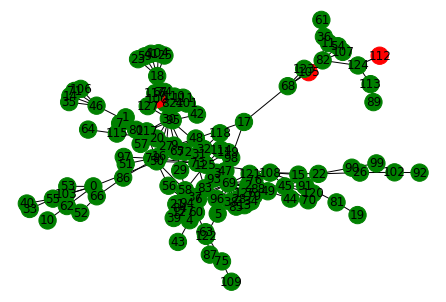

In [546]:
color_map = []
for node in G1_giant:
    if node in three_to_remove[0]:
        color_map.append('red')
    else: 
        color_map.append('green')      
nx.draw(G1_giant, node_color=color_map, with_labels=True)
plt.show()

KeyError: 0

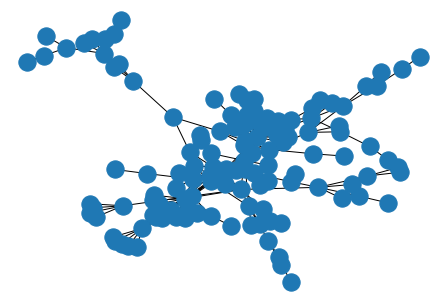

In [530]:
labels = {}    
for node in G1_giant.nodes():
    if node in diff:
        #set the node name as the key and the label as its value 
        labels[node] = node
#set the argument 'with labels' to False so you have unlabeled graph
nx.draw_spring(G1_giant, with_labels=False)
#Now only add labels to the nodes you require (the hubs in my case)
nx.draw_networkx_labels(G1_giant,labels)